### Milestone 3: Traditional statistical and machine learning methods, due Wednesday, April 19, 2017

Think about how you would address the genre prediction problem with traditional statistical or machine learning methods. This includes everything you learned about modeling in this course before the deep learning part. Implement your ideas and compare different classifiers. Report your results and discuss what challenges you faced and how you overcame them. What works and what does not? If there are parts that do not work as expected, make sure to discuss briefly what you think is the cause and how you would address this if you would have more time and resources. 

You do not necessarily need to use the movie posters for this step, but even without a background in computer vision, there are very simple features you can extract from the posters to help guide a traditional machine learning model. Think about the PCA lecture for example, or how to use clustering to extract color information. In addition to considering the movie posters it would be worthwhile to have a look at the metadata that IMDb provides. 

You could use Spark and the [ML library](https://spark.apache.org/docs/latest/ml-features.html#word2vec) to build your model features from the data. This may be especially beneficial if you use additional data, e.g., in text form.

You also need to think about how you are going to evaluate your classifier. Which metrics or scores will you report to show how good the performance is?

The notebook to submit this week should at least include:

- Detailed description and implementation of two different models
- Description of your performance metrics
- Careful performance evaluations for both models
- Visualizations of the metrics for performance evaluation
- Discussion of the differences between the models, their strengths, weaknesses, etc. 
- Discussion of the performances you achieved, and how you might be able to improve them in the future

#### Preliminary Peer Assessment

It is important to provide positive feedback to people who truly worked hard for the good of the team and to also make suggestions to those you perceived not to be working as effectively on team tasks. We ask you to provide an honest assessment of the contributions of the members of your team, including yourself. The feedback you provide should reflect your judgment of each team member’s:

- Preparation – were they prepared during team meetings?
- Contribution – did they contribute productively to the team discussion and work?
- Respect for others’ ideas – did they encourage others to contribute their ideas?
- Flexibility – were they flexible when disagreements occurred?

Your teammate’s assessment of your contributions and the accuracy of your self-assessment will be considered as part of your overall project score.

Preliminary Peer Assessment: [https://goo.gl/forms/WOYC7pwRCSU0yV3l1](https://goo.gl/forms/WOYC7pwRCSU0yV3l1)

## Below is code to implement our models. After its implementation, we describe the purpose and functionalities of the 2 models chosen applied to 2 datasets for now.

We implemented both a SGD and Random forest once on a dataset consisting of a traditional feature set holding predictors such as crew, director, actors, etc. We also implemented the same models after creating a vectorization of each movies overview description using most frequent words for classification. Below is the code to create and tune all 4 models.

In [1]:
import cPickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import make_scorer, hamming_loss, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import re
from scipy import sparse

In [2]:
def load_part(file_name):
    with open(file_name, 'rb') as handle:
        return cPickle.load(handle)

In [3]:
def cutoff_labels(labels, cutoff):
    mlb = MultiLabelBinarizer()
    label_df = pd.DataFrame(mlb.fit_transform(labels))
    label_df.columns = mlb.classes_
    label_number_df = pd.DataFrame({'cnt': label_df.sum(axis=0)})
    major_genres = set(label_number_df[label_number_df['cnt'] > cutoff].index)
    return major_genres


def get_major_genres(plot_dict):
    labels = np.array([d['genres'] for d in plot_dict.values() if 'genres' in d and 'plot' in d])
    # only leave genres mentioned in 2000 movies or more
    major_genres = cutoff_labels(labels, 2000)
    return major_genres

In [4]:
root_folder = '..'

In [5]:
# load TMDB movies dataset
tmdb_movies = load_part(root_folder + '/data/tmdb_info.pickle')

plot_dict = load_part(root_folder + '/data/plot.pickle')

cast_dict = load_part(root_folder + '/data/cast10K.pickle')

major_genres = get_major_genres(plot_dict)

sample_tmdb_ids = np.array([tmdb_id for tmdb_id, d in cast_dict.items() if
                            'genres' in d and 'genres' in plot_dict[tmdb_id] and tmdb_id in plot_dict and 'plot' in
                            plot_dict[tmdb_id]])
print len(sample_tmdb_ids)

7669


In [6]:
def prepare_text_data(tmdb_dict, plot_dict, major_genres, sample_tmdb_ids):
    # add 'overview' from TMDB to 'plot' from IMDB (it is a list)
    for tmdb_id, imdb_movie in plot_dict.iteritems():
        if ('plot' in imdb_movie and tmdb_id in tmdb_dict and 'overview' in tmdb_dict[tmdb_id].__dict__ and
                    tmdb_dict[tmdb_id].__dict__['overview'] is not None):
            imdb_movie['plot'].append(tmdb_dict[tmdb_id].__dict__['overview'])

    labels = np.array(
        [major_genres.intersection(plot_dict[tmdb_id]['genres']) for tmdb_id in sample_tmdb_ids if
         'genres' in plot_dict[tmdb_id] and 'plot' in plot_dict[tmdb_id]])
    print len(labels)

    # create the labels vector with only major genres
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    # the plot consists of a few parts, join them together
    features = np.array([''.join(plot_dict[tmdb_id]['plot']) for tmdb_id in sample_tmdb_ids if
                         'genres' in plot_dict[tmdb_id] and 'plot' in plot_dict[tmdb_id]])

    vectorizer = TfidfVectorizer(
        stop_words=stopwords.words("english"),
        token_pattern='[a-zA-Z]+[0-9]*',
        max_df=0.9,
        min_df=0.0001,
        dtype=np.float32,
    )
    return features, y, mlb.classes_, vectorizer


In [7]:
def prepare_cast_data(tmdb_dict, cast_dict, major_genres, sample_tmdb_ids):
    columns = [
        'director',
        'cast',
        'casting director',
        'miscellaneous crew',
        'original music',
        'producer',
        'cinematographer',
        'costume designer',
        'art direction']

    labels = np.array(
        [major_genres.intersection(cast_dict[tmdb_id]['genres']) for tmdb_id in sample_tmdb_ids if
         'genres' in cast_dict[tmdb_id]])
    # create the labels vector with only major genres
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)

    # combine all names separated by '|'
    features = []
    for tmdb_id in sample_tmdb_ids:
        imdb_movie = cast_dict[tmdb_id]
        if 'genres' not in imdb_movie:
            continue
        l = []
        for c in columns:
            if (c in imdb_movie):
                l = l + [c['name'].encode('utf-8') for c in imdb_movie[c]]
        # add crew and cast from TMDB
        if (tmdb_id in tmdb_dict):
            tmdb_movie = tmdb_dict[tmdb_id].__dict__
            if ('crew' in tmdb_movie):
                l = l + [c['name'].encode('utf-8') for c in tmdb_movie['crew']]
            if ('cast' in tmdb_movie):
                l = l + [c['name'].encode('utf-8') for c in tmdb_movie['cast']]
        # remove duplicates before joiniing
        features.append('|'.join(set(l)))

    vectorizer = CountVectorizer(
        max_df=0.99,
        min_df=0.0002,
        stop_words=stopwords.words("english"),
        tokenizer=lambda x: x.split('|'),
        dtype=np.float32)

    return features, y, mlb.classes_, vectorizer


In [8]:
# get labels / features from the cast / crew data
cast_features, cast_y, cast_mlb_classes, cast_vectorizer = prepare_cast_data(tmdb_movies, cast_dict, major_genres,
                                                                             sample_tmdb_ids)

print np.shape(cast_features)
print np.shape(cast_y)
print len(cast_mlb_classes)

mlb_classes = cast_mlb_classes

# get labels / features from the text data
text_features, text_y, text_mlb_classes, text_vectorizer = prepare_text_data(tmdb_movies, plot_dict, major_genres,
                                                                             sample_tmdb_ids)

print np.shape(text_features)
print np.shape(text_y)
print len(text_mlb_classes)

(7669L,)
(7669L, 15L)
15
7669
(7669L,)
(7669L, 15L)
15


In [9]:
def get_values(uni, genres):
    ret_dic = {}
    for dex, gen in enumerate(genres):
        loc = uni.find(gen)
        if dex < len(genres)-1:
            next_loc = uni.find(genres[dex+1])
            nums = re.findall(r'\d+', uni[loc+len(gen):next_loc])
            ap_dic = {'precision':float(nums[1])*.01, 'recall':float(nums[3])*.01, 'f1-score':float(nums[5])*.01, 'support':float(nums[6])}
            ret_dic[gen] = ap_dic 
    return ret_dic
def to_df(dic):
    ret_df = pd.DataFrame(columns = ['title','precision', 'recall', 'f1-score', 'support'])
    for k, v in dic.items():
        ret_df = ret_df.append({'title':k, 'precision':v['precision'], 'recall':v['recall'], 'f1-score':v['f1-score'], 'support':v['support']}, ignore_index=True)
    return ret_df

In [10]:
# split into test / train data
cast_F_train, cast_F_test, text_F_train, text_F_test, y_train, y_test = train_test_split(cast_features,
                                                                                         text_features, cast_y,
                                                                                         test_size=0.25,
                                                                                         random_state=42)

cast_X_train = cast_vectorizer.fit_transform(cast_F_train)
cast_X_test = cast_vectorizer.transform(cast_F_test)

print np.shape(cast_X_train)
print np.shape(cast_X_test)

text_X_train = text_vectorizer.fit_transform(text_F_train)
text_X_test = text_vectorizer.transform(text_F_test)

print np.shape(text_X_train)
print np.shape(text_X_test)

X_train = sparse.hstack((cast_X_train, text_X_train))
X_test = sparse.hstack((cast_X_test, text_X_test))

print np.shape(X_train)
print np.shape(X_test)


(5751, 31278)
(1918, 31278)
(5751, 35210)
(1918, 35210)
(5751, 66488)
(1918, 66488)


In [11]:
def sgd(X_test, X_train, y_test, y_train, mlb_classes):
    param_grid = {
        'estimator__alpha': np.logspace(-5, -3, num=30),
    }
    model = OneVsRestClassifier(SGDClassifier(random_state=761, class_weight='balanced'))
    model_tuning = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring=make_scorer(hamming_loss, greater_is_better=False),
        n_jobs=-1,
        verbose=1,
    )
    model_tuning.fit(X_train, y_train)
    #print model_tuning.best_params_
    #print classification_report(y_train, model_tuning.predict(X_train), target_names=mlb_classes)
    #print classification_report(y_test, model_tuning.predict(X_test), target_names=mlb_classes)
    return(classification_report(y_train, model_tuning.predict(X_train), target_names=mlb_classes), classification_report(y_test, model_tuning.predict(X_test), target_names=mlb_classes))
    
#sgd_model_analysis = sgd(X_test, X_train, y_test, y_train, mlb_classes)

In [ ]:
train, test = sgd(X_test, X_train, y_test, y_train, mlb_classes)
#this makes our sgd classification report for the crew/actor/director and overview data
crew_test_sgd_model_analysis_df = to_df(get_values(test, mlb_classes))
crew_train_sgd_model_analysis_df = to_df(get_values(train, mlb_classes))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.3s finished


In [12]:
def random_forest(X_test, X_train, y_test, y_train, mlb_classes):
    param_grid = {
        'min_samples_leaf': (1, 2, 50),
        'max_features': ('auto', 'sqrt', 'log2', 0.2),
    }
    model = RandomForestClassifier(n_estimators=50, random_state=761,class_weight='balanced')
    model_tuning = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring=make_scorer(hamming_loss, greater_is_better=False),
        cv=3,
        n_jobs=-1,
        verbose=3,
    )
    model_tuning.fit(X_train, y_train)
    #print model_tuning.best_params_
    #print classification_report(y_train, model_tuning.predict(X_train), target_names=mlb_classes)
    #print classification_report(y_test, model_tuning.predict(X_test), target_names=mlb_classes)
    return(classification_report(y_train, model_tuning.predict(X_train), target_names=mlb_classes), classification_report(y_test, model_tuning.predict(X_test), target_names=mlb_classes))
    
#forest_model_analysis = random_forest(X_test, X_train, y_test, y_train, mlb_classes)

In [ ]:
train, test = random_forest(X_test, X_train, y_test, y_train, mlb_classes)
#this makes our forest classification report for the crew/actor/director and overview data
crew_test_forest_model_analysis_df = to_df(get_values(test, mlb_classes))
crew_train_forest_model_analysis_df = to_df(get_values(train, mlb_classes))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   47.9s


# Detailed description and implementation of two different models

# Description of your performance metrics

As we described in our last milestone, we will be using a multilabel classification approach. Some movies have one genres while most have multiple genres.  This naturally creates a problem in classification as some observations fall under multiple classes. Further, making a class for every possible combination of genres is infeasible as it result in drastic class imbalances and under representation (the highly specific combinations will only have one or two corresponding movies). However, multilabel classification also has limitations, particularly when implementing and observing performance metrics. As we described previously, to run an SGD (or logistic regression, and other classifier models), we had to use an onevsrest classifier. A random forest can handle multilabel classification natively and we wanted to express the pros and cons of each model.

To analyze the models, we decided to use 3 accuracy/error based measures. Using the classification_report function in sklearn, we returned precision, recall and the f-1 score of our models across genres. In this context, precision is the fraction of correct results divided by the number of all returned results while recall is the number of correct results divided by the number of results that should have been returned. Finally, the f1-score is a measure of the model's accuracy, it considers both precision and recall to compute a score. We decided to use the f-1 score to compare the accuracy across models; we did this for several reasons, mainly because of massive class imbalance, we describe below. We considered using a roc or auc curve, but it is traditionally used in binary classification. It can adapt to the multilabel classification methodology, but it would be necessary to binarize the output of the model. Lastly, we applied the same performance metrics to the two used datasets (crew/actor/director dataset vs overview dataset). Cross comparing accuracy across datasets isn't as helpful as comparing accuracy within a dataset across models. The f1-score allows us to analyze the performance of our models which both use very different algorithms. Our visualizations reflect the differences in performance between models across both datasets.

# Careful performance evaluations for both models

#### Baseline classifier (dummy classifier) and metrics

In [14]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, zero_one_loss, jaccard_similarity_score


def evaluate_baseline(X_train, X_test, y_train, y_test, mlb_classes, strategy):
    print strategy

    num_y_columns = y_train.shape[1]

    y_test_pred_list = []
    for i in xrange(num_y_columns):
        one_y_train = y_train[:, i]
        model = DummyClassifier(strategy=strategy)
        model.fit(X_train, one_y_train)
        one_y_test_pred = model.predict(X_test)
        y_test_pred_list.append(one_y_test_pred)

    y_test_pred = np.array(y_test_pred_list).T

    print 'accuracy score: %.3f' % accuracy_score(y_test, y_test_pred)
    print 'jaccard similarity score: %.3f' % jaccard_similarity_score(y_test, y_test_pred)
    print 'hamming loss: %.3f' % hamming_loss(y_test, y_test_pred)
    print 'zero one loss: %.3f' % zero_one_loss(y_test, y_test_pred)
    print classification_report(y_test, y_test_pred, target_names=mlb_classes)


evaluate_baseline(X_train, X_test, y_train, y_test, cast_mlb_classes, 'stratified')
evaluate_baseline(X_train, X_test, y_train, y_test, cast_mlb_classes, 'uniform')
evaluate_baseline(X_train, X_test, y_train, y_test, cast_mlb_classes, 'most_frequent')

stratified
accuracy score: 0.026
jaccard similarity score: 0.136
hamming loss: 0.205
zero one loss: 0.974
             precision    recall  f1-score   support

     Action       0.09      0.10      0.09       200
  Adventure       0.10      0.09      0.10       159
  Animation       0.04      0.03      0.04       146
     Comedy       0.28      0.30      0.29       525
      Crime       0.08      0.09      0.08       181
Documentary       0.13      0.13      0.13       227
      Drama       0.43      0.43      0.43       837
     Family       0.08      0.08      0.08       149
    Fantasy       0.06      0.05      0.05       105
     Horror       0.09      0.11      0.10       178
    Mystery       0.03      0.04      0.04        93
    Romance       0.14      0.13      0.13       295
     Sci-Fi       0.07      0.07      0.07        94
      Short       0.14      0.14      0.14       200
   Thriller       0.15      0.16      0.15       264

avg / total       0.20      0.21      0.20  

C:\Users\Keenan\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
print 'Forest model run on crew/director/actor dataset'
print crew_test_forest_model_analysis_df
print 'SGD model run on crew/director/actor dataset'
print crew_test_sgd_model_analysis_df

Forest model run on crew/director/actor dataset
          title  precision  recall  f1-score  support
0       Mystery       0.00    0.00      0.00     93.0
1       Romance       0.55    0.02      0.04    295.0
2         Short       0.82    0.14      0.23    200.0
3        Sci-Fi       0.00    0.00      0.00     94.0
4        Family       0.83    0.13      0.22    149.0
5        Horror       0.00    0.01      0.01    178.0
6         Crime       0.67    0.01      0.02    181.0
7         Drama       0.61    0.65      0.63    837.0
8       Fantasy       0.00    0.00      0.00    105.0
9     Animation       0.85    0.16      0.27    146.0
10    Adventure       0.00    0.00      0.00    159.0
11       Action       0.00    0.00      0.00    200.0
12       Comedy       0.80    0.12      0.20    525.0
13  Documentary       0.91    0.34      0.49    227.0
SGD model run on crew/director/actor dataset
          title  precision  recall  f1-score  support
0       Mystery       0.22    0.24      0.2

Here I will discuss why the f1-score is best for class imbalanced data.

# Visualizations of the metrics for performance evaluation

### Models based on crew/director/feature set data

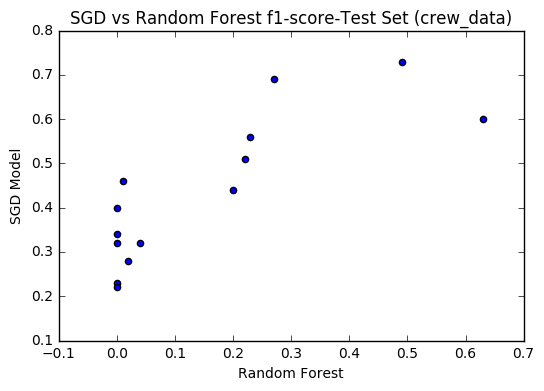

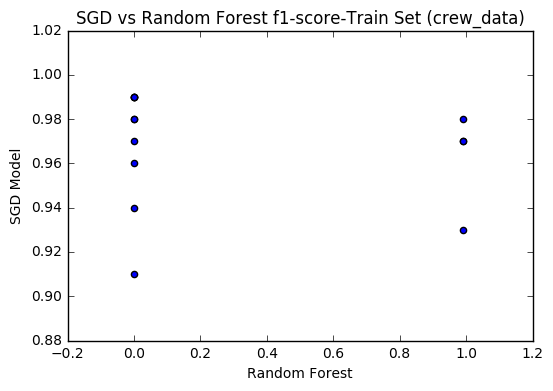

In [29]:
plt.scatter(crew_test_forest_model_analysis_df['f1-score'], crew_test_sgd_model_analysis_df['f1-score'])
plt.ylabel('SGD Model')
plt.xlabel('Random Forest')
plt.title('SGD vs Random Forest f1-score-Test Set (crew_data)')
plt.show()
plt.scatter(crew_train_forest_model_analysis_df['f1-score'], crew_train_sgd_model_analysis_df['f1-score'])
plt.ylabel('SGD Model')
plt.xlabel('Random Forest')
plt.title('SGD vs Random Forest f1-score-Train Set (crew_data)')
plt.show()

# Discussion of the differences between the models, their strengths, weaknesses, etc.

# Discussion of the performances you achieved, and how you might be able to improve them in the future